In [2]:
import pandas as pd
import os
import glob
import ast
import numpy as np
import matplotlib.pyplot as plt
from alerce.core import Alerce
from ztfquery import lightcurve
from ztfquery.io import set_account
import requests

In [3]:
set_account("irsa")

In [4]:
alerce = Alerce(ZTF_API_URL="https://api.alerce.online/ztf/v1")

In [7]:
def get_numeric_id(oid: str) -> int:
    """
    Consulta la tabla de objetos de ALeRCE para convertir el OID (cadena)
    en el objectid numérico usado por IRSA.
    """
    alerce = Alerce(ZTF_API_URL="https://api.alerce.online/ztf/v1")
    # La tabla se llama 'objects'; devuelve la columna 'objectid'
    query = f"SELECT objectid FROM objects WHERE oid = '{oid}'"
    df = alerce.send_query(query, format="pandas")
    if df.empty:
        raise RuntimeError(f"No se encontró objectid para {oid}")
    return int(df.loc[0, "objectid"])

In [23]:
def download_lightcurve_by_oid(oid: str,
                               radius_arcsec: float = 3.0,
                               dr: str = "ztf_dr5",
                               outdir: str = ".") -> str:
    """
    1. Usa query_object para obtener meanra/meandec
    2. Descarga la curva de luz de IRSA-ZTF-LC usando POS=circle RA DEC RADIUS,
       filtra solo bandas 'g' y 'r' con BANDNAME=g,r, y guarda el CSV.
    """
    # 1. Obtener posición desde ALeRCE
    client = Alerce()
    df_obj = client.query_object(oid, format="pandas")
    if df_obj.empty:
        raise RuntimeError(f"No se encontró información para {oid}")

    ra  = float(df_obj.loc[0, "meanra"])
    dec = float(df_obj.loc[0, "meandec"])
    radius_deg = radius_arcsec / 3600.0

    # 2. Preparar la consulta con BANDNAME=g,r
    base_url = "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves"
    params = {
        # POS must be "circle RA DEC RADIUS" (elements separated by single spaces) :contentReference[oaicite:0]{index=0}
        "POS":        f"circle {ra} {dec} {radius_deg}",
        # Filter only g- and r-band data; comma-separated list :contentReference[oaicite:1]{index=1}
        "BANDNAME":   "g,r",
        # Select the desired Data Release (ztf_dr18 here) :contentReference[oaicite:2]{index=2}
        "COLLECTION": dr,
        "FORMAT":     "csv"
    }

    # 3. Ejecutar la petición y guardar el CSV
    resp = requests.get(base_url, params=params)
    resp.raise_for_status()

    fn   = f"{oid}_{dr}_lightcurve.csv"
    path = os.path.join(outdir, fn)
    with open(path, "wb") as f:
        f.write(resp.content)

    print(f"✔ Curva de luz (g,r) descargada en: {path}")
    return path

In [24]:
download_lightcurve_by_oid("ZTF20acxqjzv", outdir="data")

HTTPError: 400 Client Error: Bad Request for url: https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=circle+86.59847642708105+20.064870597379812+0.0008333333333333334&BANDNAME=g%2Cr&COLLECTION=ztf_dr5&FORMAT=csv

In [30]:
oids = [
    "ZTF18accqogs",
    "ZTF19aakyhxi",
    "ZTF19abyylzv",
    "ZTF19acyfpno",
]
alerce = Alerce()
objects = alerce.query_objects(oid=oids, format="pandas")

In [32]:
objects.columns

Index(['oid', 'ndethist', 'ncovhist', 'mjdstarthist', 'mjdendhist',
       'corrected', 'stellar', 'ndet', 'g_r_max', 'g_r_max_corr', 'g_r_mean',
       'g_r_mean_corr', 'firstmjd', 'lastmjd', 'deltajd', 'meanra', 'meandec',
       'sigmara', 'sigmadec', 'class', 'classifier', 'probability',
       'step_id_corr'],
      dtype='object')

In [25]:
csv_file = "veto_summary.csv"

df_summary = pd.read_csv(
    csv_file,
    parse_dates=["veto_date"],
    dtype={"oid": str, "label": "category"}
)
df_summary.set_index("oid", inplace=True)

# Ver las primeras filas para comprobar
print(df_summary.head())
print(df_summary.dtypes)

              veto_date label
oid                          
ZTF23abgzrmz 2023-09-26   bad
ZTF23abhayrq 2023-09-26   bad
ZTF23abgovnz 2023-09-26   bad
ZTF23abfwupu 2023-09-24   bad
ZTF23abgouvq 2023-09-26   bad
veto_date    datetime64[ns]
label              category
dtype: object


In [7]:
def procesar_folder(folder_path):
    all_dfs = []
    pattern = os.path.join(folder_path, "*_detections.csv")
    for filepath in glob.glob(pattern):
        # Obtener oid desde el nombre de archivo: e.g. "12345_detections.csv"
        oid = os.path.basename(filepath).split("_")[0]
        if oid not in df_summary.index:
            # OID no está en el summary; opcionalmente saltar o avisar
            continue

        # Leer CSV de detecciones; suponemos que hay una columna 'detections'
        df_det = pd.read_csv(filepath, dtype={"detections": str})
        if "detections" not in df_det.columns:
            raise ValueError(f"El archivo {filepath} no contiene la columna 'detections'")

        # Convertir cada fila de texto a lista de dicts
        registros = []
        for det_str in df_det["detections"]:
            # ast.literal_eval para convertir string a lista de dicts
            try:
                lista = ast.literal_eval(det_str)
            except Exception as e:
                raise ValueError(f"Error al parsear detections en {filepath}: {e}")
            registros.extend(lista)

        # Normalizar lista de dicts a DataFrame
        df_norm = pd.json_normalize(registros)
        # Añadir columnas de contexto
        df_norm["oid"] = oid
        df_norm["veto_date"] = df_summary.loc[oid, "veto_date"]
        df_norm["label"]     = df_summary.loc[oid, "label"]
        all_dfs.append(df_norm)

    # Concatenar todos de este folder (puede estar vacío)
    return pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()

In [26]:

stats_file   = "statistics_lightcurve_alerts.csv"   # oid,n_points,mag_min,...,excess_variance
lc_file      = "all_alert_lightcurves_clean.csv"   # oid,mjd,magpsf,sigmapsf,fid,source
summary_file = "veto_summary.csv"                  # oid,veto_date,label

df_stats   = pd.read_csv(stats_file,   dtype={"oid": str})
df_lc      = pd.read_csv(lc_file,      dtype={"oid": str})
df_summary = pd.read_csv(summary_file, parse_dates=["veto_date"], dtype={"oid": str, "label": "category"})

In [27]:
# Merge
df_consolidated = (
    df_lc
    .merge(df_stats,   on="oid", how="left")
    .merge(df_summary, on="oid", how="left")
)

cols_order = (
    ["oid", "veto_date", "label"]
    + [c for c in df_stats.columns if c != "oid"]
    + [c for c in df_lc.columns    if c not in ("oid",)]
)

other_cols = [c for c in df_consolidated.columns if c not in cols_order]
df_consolidated = df_consolidated[cols_order + other_cols]

In [28]:
output_file = "consolidated.csv"
df_consolidated.to_csv(output_file, index=False)

print(f"Archivo combinado guardado en: {output_file}")

Archivo combinado guardado en: consolidated.csv


In [40]:
# Getting detections for an object
detections = alerce.query_detections("ZTF18abbuksn",
                                     format="json")

# Getting non detections for an object
non_detections = alerce.query_non_detections("ZTF18abbuksn",
                                             format="json")

# Getting forced photometry for an object
non_detections_forced = alerce.query_forced_photometry("ZTF18abbuksn",
                                             format="json")
# Getting lightcurve for an object
lightcurve = alerce.query_lightcurve("ZTF18abbuksn",
                                     format="json")

In [39]:
detections[0].keys()

dict_keys(['tid', 'mjd', 'candid', 'fid', 'pid', 'diffmaglim', 'isdiffpos', 'nid', 'distnr', 'magpsf', 'magpsf_corr', 'magap', 'sigmapsf', 'sigmapsf_corr', 'sigmapsf_corr_ext', 'sigmagap', 'ra', 'dec', 'rb', 'drb', 'magapbig', 'sigmagapbig', 'rfid', 'has_stamp', 'corrected', 'dubious', 'step_id_corr', 'phase', 'parent_candid'])

In [42]:
non_detections[0].keys()

dict_keys(['tid', 'mjd', 'fid', 'diffmaglim'])

In [43]:
non_detections_forced[0].keys()

dict_keys(['candid', 'tid', 'pid', 'oid', 'mjd', 'fid', 'ra', 'e_ra', 'dec', 'e_dec', 'mag', 'e_mag', 'mag_corr', 'e_mag_corr', 'e_mag_corr_ext', 'isdiffpos', 'corrected', 'dubious', 'parent_candid', 'has_stamp', 'scibckgnd', 'exptime', 'magnr', 'scisigpix', 'adpctdif1', 'sigmagnr', 'magzpsci', 'adpctdif2', 'chinr', 'diffmaglim', 'programid', 'sharpnr', 'field', 'magzpsciunc', 'procstatus', 'rcid', 'magzpscirms', 'distnr', 'rfid', 'clrcoeff', 'ranr', 'sciinpseeing', 'clrcounc', 'decnr'])

In [46]:
lightcurve.keys()

dict_keys(['detections', 'non_detections'])

In [ ]:
def plot_lightcurves(oid: str,
                     file1: str = "all_alert_lightcurves_clean.csv",
                     file2: str = "lc_consolidated.csv") -> None:
    """
    Carga dos CSVs de curvas de luz, filtra por el oid dado
    y plotea ambas series de magpsf vs mjd en un mismo gráfico.
    """
    # 1. Leer los CSVs
    df1 = pd.read_csv(file1, dtype={"oid": str})
    df2 = pd.read_csv(file2, dtype={"oid": str})

    # 2. Filtrar por el oid
    df1_oid = df1[df1["oid"] == oid]
    df2_oid = df2[df2["oid"] == oid]

    # 3. Crear el gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(df1_oid["mjd"], df1_oid["magpsf"],
             marker="o", linestyle="-", label="all_alert_lightcurves_clean")
    plt.plot(df2_oid["mjd"], df2_oid["magpsf"],
             marker="s", linestyle="--", label="lc_consolidated")

    # Magnitudes astronómicas van al revés
    plt.gca().invert_yaxis()

    # Etiquetas y leyenda
    plt.xlabel("MJD")
    plt.ylabel("magpsf")
    plt.title(f"Curvas de luz para {oid}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Mostrar
    plt.show()

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_20188\3147114501.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(file2, dtype={"oid": str})


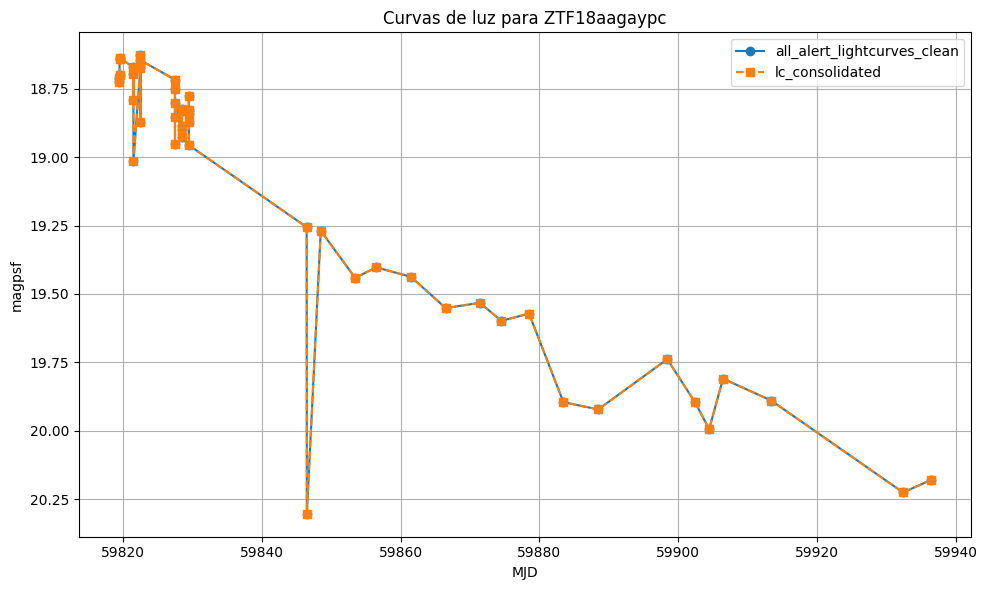

In [53]:
plot_lightcurves("ZTF18aagaypc")

In [ ]:
df.to_parquet(
    "labels.parquet",
    engine="pyarrow",        # o "fastparquet"
    compression="snappy"     # u otro compresor
)